In [ ]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from keras.preprocessing import image

In [ ]:
!ls ../input/pretrained-pytorch-models

In [ ]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [ ]:
!cp ../input/pretrained-pytorch-models/* ~/.torch/models

In [ ]:
!ls ~/.torch/models

In [76]:
INPUT_SIZE = 224
NUM_CLASSES = 120
data_dir = '../input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [77]:
selected_breed_list = list(labels.groupby('breed').count().head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(8178, 121) (2044, 121)


In [ ]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'/train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'/train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [102]:
def imshow(axis, inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    axis.axis('off')
    axis.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    imshow(grid[i], img[i])

In [ ]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloaders['train'].dataset), 
                     'valid': len(dataloaders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 120)
if torch.cuda.is_available():
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [ ]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler)
print('Training time: {:2f} minutes'.format((time.time()-start_time)/60))

In [93]:
def visualize_model(dataloaders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            
            prediction = selected_breed_list[preds[j]]
            actual = selected_breed_list[labels.data[j]]
            color = 'r'
            
            if prediction == actual:
                color = 'g'
            ax.text(10, 180, 'Predicted: %s' % prediction, color='w', backgroundcolor=color, alpha=0.8)
            ax.text(10, 200, 'Actual:      %s' % actual, color='k', backgroundcolor='w', alpha=0.8)
                
            cnt += 1
            if cnt == num_images:
                return

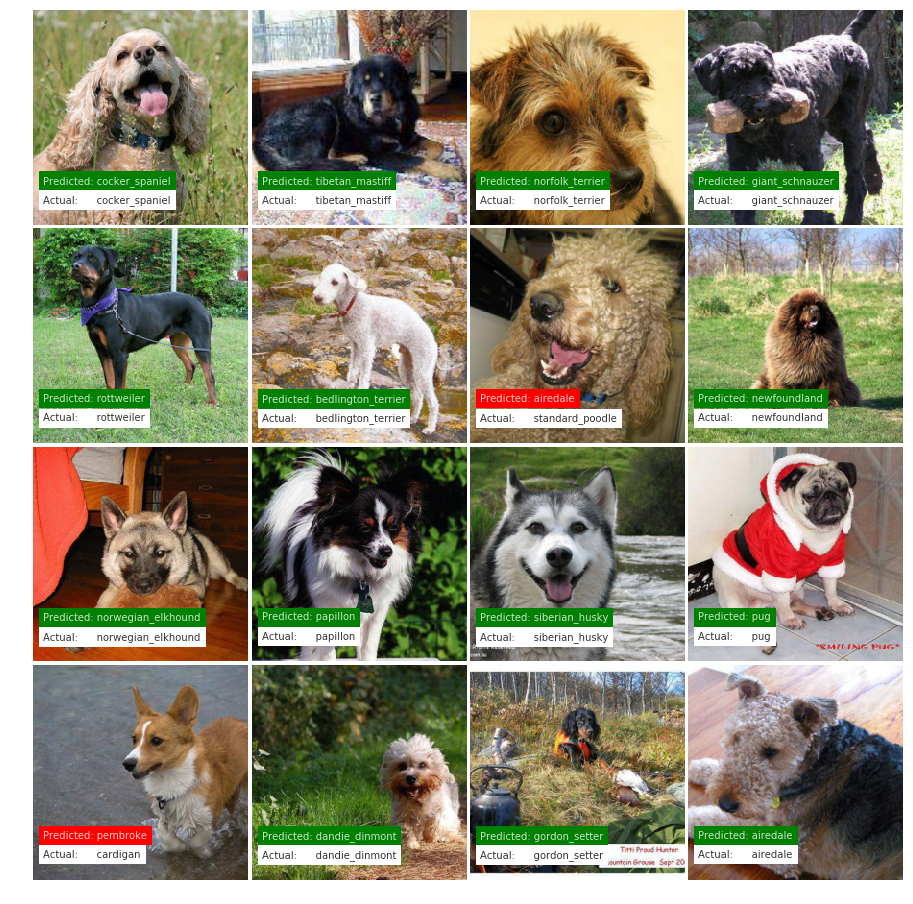

In [94]:
visualize_model(dloaders, resnet)

In [132]:
def predict(pic, model):
    dog = image.load_img('../input/dogphotos/' + pic)
    
    input = Variable(ds_trans(dog).unsqueeze(0).cuda())
    output = model(input)
    _, pred = torch.max(output.data, 1)
    
    prediction = selected_breed_list[pred[0]]
    prediction = prediction.replace("_", " ").title()
    
    plt.imshow(dog)
    plt.title(prediction, fontsize=15)
    plt.axis('off')

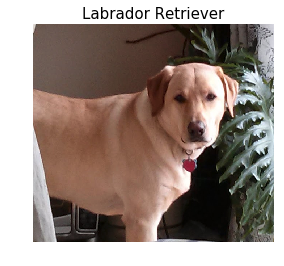

In [134]:
predict('buddy1.png', resnet)

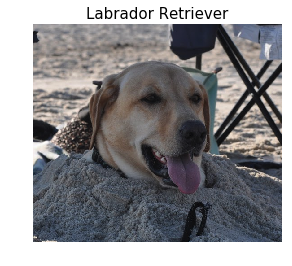

In [135]:
predict('buddy2.png', resnet)